# Згортковий автоенкодер для усунення шумів зображення

**Опис:** Як навчити глибокий згортковий автоенкодер для зменшення шуму зображення.

## Вступ

Цей приклад демонструє, як реалізувати глибокий згортковий автокодер для усунення шумів зображення, зіставляючи зашумлені цифрові зображення з набору даних MNIST на чисті цифрові зображення. Ця реалізація заснована на оригінальній публікації в блозі під назвою [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet].

## Завантаження бібліотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Підготовка даних

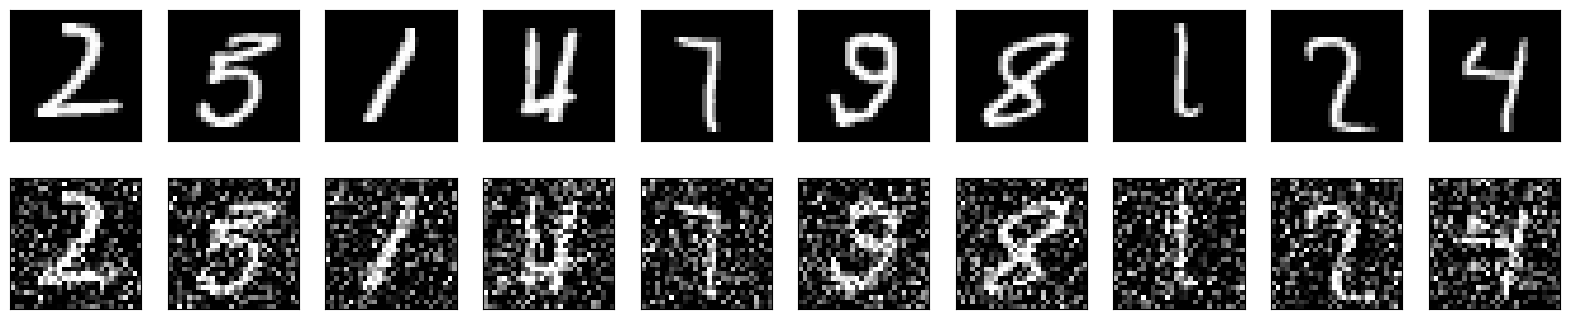

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Побудова автоенкодеру

Нижче використано функціональний API для створення нашого згорткового автокодувальника.

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Начимо автоенкодер, який створено, використовуючи `train_data` як наші вхідні дані та ціль. Зауважте, що ми налаштовуємо дані перевірки, використовуючи той самий формат.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - loss: 0.2520 - val_loss: 0.0731
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 0.0726 - val_loss: 0.0694
Epoch 3/50
182/469 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0698

KeyboardInterrupt: 

Далі виконано прогноз для тестового набору даних і відображено оригінальне зображення разом із прогнозом від нашого автокодувальника.

Зверніть увагу, що прогнози досить близькі до оригінальних зображень, хоча й не зовсім такі.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


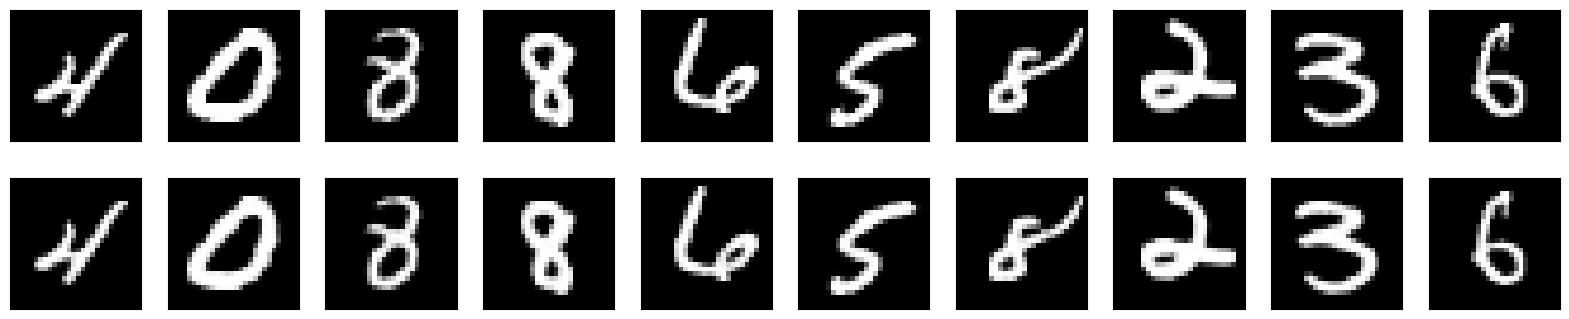

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Тепер, коли ми знаємо, що наш автокодер працює, давайте перенавчимо його, використовуючи дані з шумом як вхідні дані та чисті дані як ціль. Ми хочемо, щоб наш автокодер навчився знімати шуми в зображеннях.

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1164 - val_loss: 0.0939
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0941 - val_loss: 0.0918
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0919 - val_loss: 0.0905
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0909 - val_loss: 0.0899
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0901 - val_loss: 0.0892
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0897 - val_loss: 0.0887
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0892 - val_loss: 0.0883
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0887 - val_loss: 0.0881
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0883 - val_loss: 0.0876
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0883 - val_loss: 0.0874
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0878 - val_loss: 0.0871
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

Далі виконано прогноз для даних з шумом і відображено результати роботи автокодувальника.

Зверніть увагу на те, що автокодер чудово справляється з видаленням шумів із вхідних зображень.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


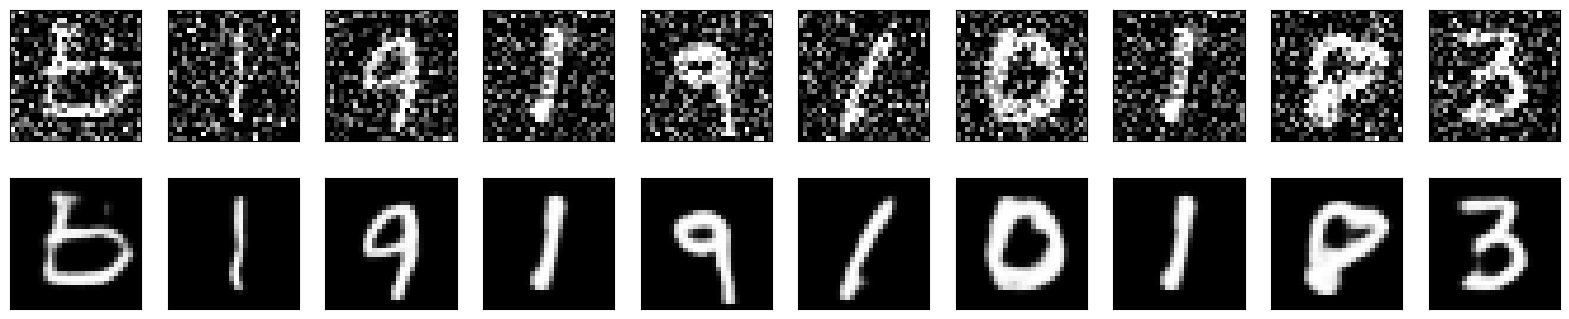

In [7]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# **Завдання**

1. Спробуйте змінити кількість нейронів в енкодері та декодері. Перевірьте, як це вплине на результат і час навчаеея моделі.
2. Виконайте ті ж самі операції - додавання шуму та його видалення за допомогою автоенкодера - для іншого набору даних - flowers, street view house numbers (або інший набір, за вашим вибором).